In [4]:
import logging

import matplotlib.pyplot as plt
import networkx as nx
import pymimir as mi
import torch
import torch_geometric as pyg

from rgnet.encoding import ColorGraphEncoder
from rgnet.utils import import_all_from, import_problems
from rgnet.supervised.data import MultiInstanceSupervisedSet

In [5]:
logging.getLogger().setLevel(logging.INFO)

In [18]:
domain = mi.DomainParser("test/pddl_instances/blocks/domain.pddl").parse()
problem = mi.ProblemParser("test/pddl_instances/blocks/medium.pddl").parse(domain)
state_space = mi.StateSpace.new(problem, mi.GroundedSuccessorGenerator(problem))
state = state_space.get_initial_state()
encoder = ColorGraphEncoder(domain)
graph = encoder.encode(state)

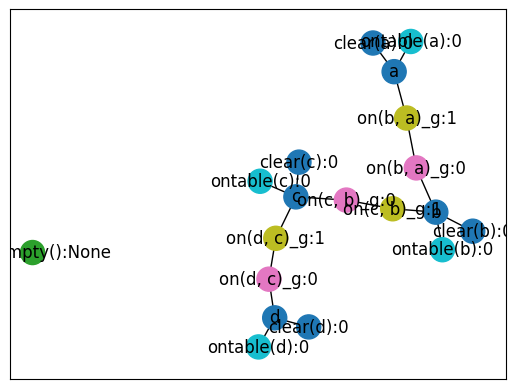

In [8]:
nx.draw_networkx(
    graph,
    with_labels=True,
    labels={n: str(n) for n in graph.nodes},
    nodelist=[n for n in graph.nodes],
    node_color=[attr["feature"] for _, attr in graph.nodes.data()],
    cmap="tab10",
)

In [19]:
data = encoder.to_pyg_data(graph)

In [20]:
from rgnet.model.pure_gnn import PureGNN

In [21]:
model = PureGNN(size_in=1, size_embedding=32,size_out=1, num_layer=4)
model.train()
out = model(data.x, data.edge_index,
            batch=torch.zeros(data.x.shape[0],
                              dtype=torch.int64))  # batch assigns nodes to graphs

In [22]:
out

tensor([0.5192], grad_fn=<ViewBackward0>)

In [23]:
import tempfile
tempdir: str = tempfile.mkdtemp()

In [24]:
domain, problems = import_all_from("data/pddl_domains/blocks")
problems

[<Problem 'blocks-6-1 (probBLOCKS-6-1.pddl)'>,
 <Problem 'blocks-4-1 (probBLOCKS-4-1.pddl)'>,
 <Problem 'blocks-4-0 (probBLOCKS-4-0.pddl)'>,
 <Problem 'blocks-5-2 (probBLOCKS-5-2.pddl)'>,
 <Problem 'blocks-6-0 (probBLOCKS-6-0.pddl)'>,
 <Problem 'blocks-4-2 (probBLOCKS-4-2.pddl)'>,
 <Problem 'blocks-5-0 (probBLOCKS-5-0.pddl)'>,
 <Problem 'blocks-6-2 (probBLOCKS-6-2.pddl)'>,
 <Problem 'blocks-7-0 (probBLOCKS-7-0.pddl)'>,
 <Problem 'blocks-7-1 (probBLOCKS-7-1.pddl)'>,
 <Problem 'blocks-5-1 (probBLOCKS-5-1.pddl)'>]

In [25]:
train_set = MultiInstanceSupervisedSet(problems, ColorGraphEncoder(domain),
                                       root=tempdir, log=True)

Processing...
INFO:root:Processed 1 / 11 problems
INFO:root:Processed 2 / 11 problems
INFO:root:Processed 3 / 11 problems
INFO:root:Processed 4 / 11 problems
INFO:root:Processed 5 / 11 problems
INFO:root:Processed 6 / 11 problems
INFO:root:Processed 7 / 11 problems
INFO:root:Processed 8 / 11 problems
INFO:root:Processed 9 / 11 problems
INFO:root:Processed 10 / 11 problems
INFO:root:Processed 11 / 11 problems
Done!


In [26]:
train_set.x

tensor([[ 1.],
        [ 1.],
        [ 1.],
        ...,
        [15.],
        [12.],
        [15.]])

In [27]:
eval_problems = import_problems("data/pddl_domains/blocks/eval", domain)
eval_problems

[<Problem 'blocks-7-2 (probBLOCKS-7-2.pddl)'>]

In [28]:
eval_set = MultiInstanceSupervisedSet(eval_problems, ColorGraphEncoder(domain),
                                      root="data/datasets/blocks/eval", log=True)

In [29]:
eval_set.len()

65990

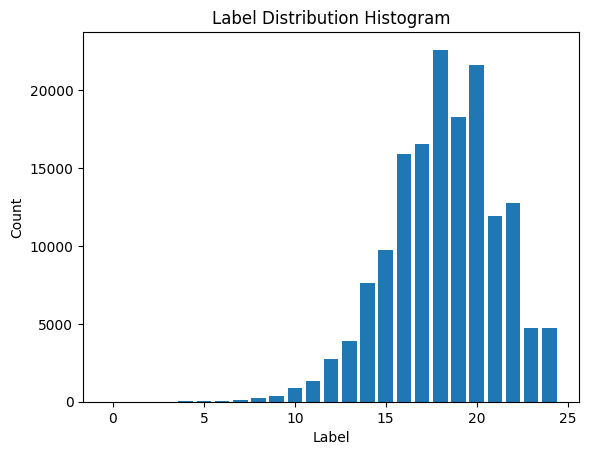

In [30]:
# Assuming 'train_set.y' is your tensor containing labels
label_distribution = train_set.get_label_distribution()

# Plot histogram
plt.bar(torch.arange(len(label_distribution)), label_distribution)

# Add labels and title
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Label Distribution Histogram')

# Show plot
plt.show()

In [31]:
train_set.print_summary()

100%|██████████| 156124/156124 [00:13<00:00, 11292.62it/s]

MultiInstanceSupervisedSet (#graphs=156124):
+------------+----------+----------+
|            |   #nodes |   #edges |
|------------+----------+----------|
| mean       |     32.3 |     69.4 |
| std        |      2.4 |      5.7 |
| min        |     17   |     32   |
| quantile25 |     32   |     68   |
| median     |     32   |     70   |
| quantile75 |     34   |     74   |
| max        |     34   |     76   |
+------------+----------+----------+


In [33]:
print("Standard deviation and mean of labels:", torch.std_mean(train_set.y.float()))

Standard deviation and mean of labels: (tensor(3.0054), tensor(18.1942))
